# experiments on k-class hierarchy classification

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), ".."))

import numpy as np
import torch
from torch.nn import functional
import copy
import matplotlib.pyplot as plt
import os
import json
from core.GMC import GMC
import h5py
import cv2
from utils.utils import eval, plot_result, eval2
from sklearn.model_selection import train_test_split

Our goal:
$\mathbb{E}[g(o(x))(\sum_{v}(\mathbb{1}_{q(v)>\lambda(x)}y)]-\sigma)\leq \alpha$


In [3]:
sigma = 0.9
alpha = 0.02

In [4]:
data_path = os.path.join(os.getcwd(), '..\datasets\HierClass\Result')

In [5]:
# label_dict: label:label_name
# slot2value: father:child list
# depth_dict: label:depth
# depth2label: depth:label list
# value2slot: child:father
def get_depth(value2slot, x):
    depth = 0
    while value2slot[x] != -1:
        depth += 1
        x = value2slot[x]
    return depth

label_dict = torch.load(os.path.join(data_path, 'value_dict.pt'))
label_dict = {i: v for i, v in label_dict.items()}

slot2value = torch.load(os.path.join(data_path, 'slot.pt'))
value2slot = {}
num_class = 0
for s in slot2value:
    for v in slot2value[s]:
        value2slot[v] = s
        if num_class < v:
            num_class = v
num_class += 1
path_list = [(i, v) for v, i in value2slot.items()]
for i in range(num_class):
    if i not in value2slot:
        value2slot[i] = -1

depth_dict = {i: get_depth(value2slot, i) for i in range(num_class)}
max_depth = depth_dict[max(depth_dict, key=depth_dict.get)] + 1
depth2label = {i: [a for a in depth_dict if depth_dict[a] == i] for i in range(max_depth)}

In [22]:
for i in range(7):
    print(len(slot2value[i]))

17
53
11
16
9
9
19


In [21]:
y2 = np.array([value2slot[i] for i in y])
for i in range(7):
    print(sum(y2==i))

1287
2842
826
1131
1179
707
1425


In [7]:
print(label_dict)

{0: 'CS', 1: 'Medical', 2: 'Civil', 3: 'ECE', 4: 'biochemistry', 5: 'MAE', 6: 'Psychology', 7: 'Symbolic computation', 8: "Alzheimer's Disease", 9: 'Green Building', 10: 'Electric motor', 11: "Parkinson's Disease", 12: 'Computer vision', 13: 'Molecular biology', 14: 'Fluid mechanics', 15: 'Prenatal development', 16: 'Sprains and Strains', 17: 'Enzymology', 18: 'Southern blotting', 19: 'Cancer', 20: 'Northern blotting', 21: 'Sports Injuries', 22: 'Senior Health', 23: 'Computer graphics', 24: 'Digital control', 25: 'Human Metabolism', 26: 'Polymerase chain reaction', 27: 'Multiple Sclerosis', 28: 'Operating systems', 29: 'Microcontroller', 30: 'Attention', 31: 'Immunology', 32: 'Genetics', 33: 'Water Pollution', 34: 'Hydraulics', 35: 'Hepatitis C', 36: 'Weight Loss', 37: 'Machine learning', 38: 'Low Testosterone', 39: 'Fungal Infection', 40: 'Diabetes', 41: 'Data structures', 42: 'Cell biology', 43: 'Parenting', 44: 'Birth Control', 45: 'Smart Material', 46: 'network security', 47: 'Hear

In [8]:
def nearest_common_ancestor(x,y):
    if x==y:
        return x
    elif value2slot[x]==value2slot[y]:
        return value2slot[x]
    else:
        return 141 #141 stands for root

def get_r(h):
    g = np.ones((h.shape[0], h.shape[1]+1))
    g[:, :h.shape[1]] = copy.deepcopy(h)
    for i in range(7):
        g[:,i] = np.sum(h[:,list(slot2value[i])], axis=-1)
    g[:,141] = np.sum(g[:,:7], axis=-1)
    return g

f = h5py.File(os.path.join(data_path, 'result.h'), 'r')
h = f['h'][:,1,:]
# turn h into [0,1]
h = torch.softmax(torch.Tensor(h), dim=-1).numpy()
f2 = h5py.File(os.path.join(data_path, 'label.h'), 'r')
y = np.argmax(f2['y'][:, -141:],axis=-1)
u = np.argmax(h, axis=-1)
print('shape of h: ', h.shape)
print('shape of y: ', y.shape)
print('shape of u: ', u.shape)
r = get_r(h)
print('shape of r: ', r.shape)
for i in range(h.shape[0]):
    for v in range(7,141):
        h[i,v]=r[i,nearest_common_ancestor(u[i],v)]
processed_h = h[:, :141]
ancestor = np.ones((h.shape[0],3))
ancestor_r = np.ones((h.shape[0],3))
for i in range(h.shape[0]):
    ancestor[i,:] = np.array([u[i], value2slot[u[i]], 141])
    ancestor_r[i,:] = np.array([r[i,u[i]], r[i,value2slot[u[i]]],r[i,141]])
ancestor_info = np.concatenate([ancestor, ancestor_r], axis=-1)
print(ancestor_info.shape)
ancestor_cal, ancestor_test, h_cal, h_test, y_cal, y_test = train_test_split(ancestor_info, processed_h, y, test_size=0.5, random_state=43) 

shape of h:  (9397, 141)
shape of y:  (9397,)
shape of u:  (9397,)
shape of r:  (9397, 142)
(9397, 6)


In [9]:
def generate_G():
    G = []
    G.append(lambda x:(x>=0).astype('int64'))
    G.append(lambda x:((x==0)+(x==99)+(x==101)+(x==37)+(x==7)+(x==41)+(x==12)+(x==140)+(x==46)+(x==110)+(x==111)+(x==49)+(x==50)+(x==23)+(x==57)+(x==91)+(x==28)+(x==125)).astype('int64'))
    G.append(lambda x:((x==1)+(x==128)+(x==129)+(x==131)+(x==132)+(x==134)+(x==135)+(x==8)+(x==138)+(x==11)+(x==139)+(x==16)+(x==19)+(x==21)+(x==22)+(x==27)+(x==35)+(x==36)+(x==38)+(x==39)+(x==40)+(x==43)+(x==44)+(x==47)+(x==52)+(x==53)+(x==54)+(x==63)+(x==65)+(x==68)+(x==69)+(x==70)+(x==72)+(x==73)+(x==74)+(x==75)+(x==76)+(x==78)+(x==80)+(x==85)+(x==89)+(x==106)+(x==107)+(x==108)+(x==109)+(x==112)+(x==114)+(x==115)+(x==116)+(x==117)+(x==121)+(x==124)+(x==126)+(x==127)).astype('int64'))
    G.append(lambda x:((x==2)+(x==33)+(x==66)+(x==71)+(x==9)+(x==45)+(x==82)+(x==51)+(x==83)+(x==118)+(x==56)+(x==120)).astype('int64'))
    G.append(lambda x:((x==3)+(x==98)+(x==58)+(x==102)+(x==103)+(x==10)+(x==79)+(x==113)+(x==84)+(x==55)+(x==24)+(x==90)+(x==59)+(x==60)+(x==29)+(x==62)+(x==95)).astype('int64'))
    G.append(lambda x:((x==4)+(x==32)+(x==42)+(x==13)+(x==17)+(x==18)+(x==20)+(x==25)+(x==26)+(x==31)).astype('int64'))
    G.append(lambda x:((x==5)+(x==34)+(x==67)+(x==77)+(x==14)+(x==48)+(x==81)+(x==92)+(x==61)+(x==94)).astype('int64'))
    G.append(lambda x:((x==6)+(x==130)+(x==133)+(x==136)+(x==137)+(x==15)+(x==30)+(x==64)+(x==86)+(x==87)+(x==88)+(x==93)+(x==96)+(x==97)+(x==100)+(x==104)+(x==105)+(x==119)+(x==122)+(x==123)).astype('int64'))
    G.append(lambda x:-(x>=0).astype('int64'))
    G.append(lambda x:-((x==0)+(x==99)+(x==101)+(x==37)+(x==7)+(x==41)+(x==12)+(x==140)+(x==46)+(x==110)+(x==111)+(x==49)+(x==50)+(x==23)+(x==57)+(x==91)+(x==28)+(x==125)).astype('int64'))
    G.append(lambda x:-((x==1)+(x==128)+(x==129)+(x==131)+(x==132)+(x==134)+(x==135)+(x==8)+(x==138)+(x==11)+(x==139)+(x==16)+(x==19)+(x==21)+(x==22)+(x==27)+(x==35)+(x==36)+(x==38)+(x==39)+(x==40)+(x==43)+(x==44)+(x==47)+(x==52)+(x==53)+(x==54)+(x==63)+(x==65)+(x==68)+(x==69)+(x==70)+(x==72)+(x==73)+(x==74)+(x==75)+(x==76)+(x==78)+(x==80)+(x==85)+(x==89)+(x==106)+(x==107)+(x==108)+(x==109)+(x==112)+(x==114)+(x==115)+(x==116)+(x==117)+(x==121)+(x==124)+(x==126)+(x==127)).astype('int64'))
    G.append(lambda x:-((x==2)+(x==33)+(x==66)+(x==71)+(x==9)+(x==45)+(x==82)+(x==51)+(x==83)+(x==118)+(x==56)+(x==120)).astype('int64'))
    G.append(lambda x:((x==3)+(x==98)+(x==58)+(x==102)+(x==103)+(x==10)+(x==79)+(x==113)+(x==84)+(x==55)+(x==24)+(x==90)+(x==59)+(x==60)+(x==29)+(x==62)+(x==95)).astype('int64'))
    G.append(lambda x:-((x==4)+(x==32)+(x==42)+(x==13)+(x==17)+(x==18)+(x==20)+(x==25)+(x==26)+(x==31)).astype('int64'))
    G.append(lambda x:-((x==5)+(x==34)+(x==67)+(x==77)+(x==14)+(x==48)+(x==81)+(x==92)+(x==61)+(x==94)).astype('int64'))
    G.append(lambda x:-((x==6)+(x==130)+(x==133)+(x==136)+(x==137)+(x==15)+(x==30)+(x==64)+(x==86)+(x==87)+(x==88)+(x==93)+(x==96)+(x==97)+(x==100)+(x==104)+(x==105)+(x==119)+(x==122)+(x==123)).astype('int64'))
    return G
G = generate_G()

In [10]:
def GMC(alpha, eta, x_cal, y_cal, h_cal, x_test, h_test, s, group_G, f=(lambda x:0), f_test = (lambda x:0), T=500, proj=None):
    fx = f(x_cal)
    fx_test = f_test(x_test)
    n = x_cal.shape[0]
    n2 = x_test.shape[0]
    for i in range(T):
        update = False
        for g in group_G:
            output = (x_cal[:,3:]>fx[:,None].repeat(3, axis=-1)).astype('int64')
            output[:,1:] -= output[:,:2]
            output = np.sum(output*x_cal[:,:3], axis=-1)
            #print(g(output)@s(fx, x_cal, y_cal, h_cal))
            if g(output)@s(fx, x_cal, y_cal, h_cal)>alpha*n:
                update = True
                print(group_G.index(g), g(output)@s(fx, x_cal, y_cal, h_cal))
                break
        if update==False:
            print(i)
            print('end')
            break
        else:
            output_test = (x_test[:,3:]>fx_test[:,None].repeat(3, axis=-1)).astype('int64')
            output_test[:,1:] -= output_test[:,:2]
            output_test = np.sum(output_test*x_test[:,3:], axis=-1)
            fx = fx - eta*g(output)
            fx_test = fx_test - eta*g(output_test)
            if not (proj is None):
                fx = proj(fx)
                fx_test = proj(fx_test)
    return fx, fx_test

def s(lamda, x, y, h):
    shape2 = h.shape[1]
    lamda = lamda[:,None].repeat(shape2,axis=1)
    intersect = (h>lamda).astype('int64')[[i for i in range(h.shape[0])], y]
    return sigma-intersect

ancestor_cal, ancestor_test, h_cal, h_test, y_cal, y_test = train_test_split(ancestor_info, processed_h, y, test_size=0.3, random_state=1) 
eta = 0.0002
# x: [ancestor,ancestor_r]
fx, fx_test = GMC(alpha*3/4, eta, ancestor_cal, y_cal, h_cal, ancestor_test, h_test, s, G, f=(lambda x:0.76*np.ones(ancestor_cal.shape[0])),f_test=(lambda x:0.76*np.ones(ancestor_test.shape[0])),T=5000)
G2 = [lambda x:(x>=0).astype('int64'), lambda x:-(x>=0).astype('int64')]
fx_b, fx_test_b = GMC(alpha*3/4, eta, ancestor_cal, y_cal, h_cal, ancestor_test, h_test, s, G2, f=(lambda x:0.76*np.ones(ancestor_cal.shape[0])),f_test=(lambda x:0.76*np.ones(ancestor_test.shape[0])),T=5000)

1 163.70000000000016
1 163.70000000000016
1 162.80000000000015
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 161.90000000000018
1 160.00000000000014
1 159.10000000000016
1 159.10000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 158.20000000000016
1 157.30000000000015
1 157.30000000000015
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 156.40000000000018
1 155.50000000000014
1 155.50000000000014
1 155.50000000000014
1 155.5000000

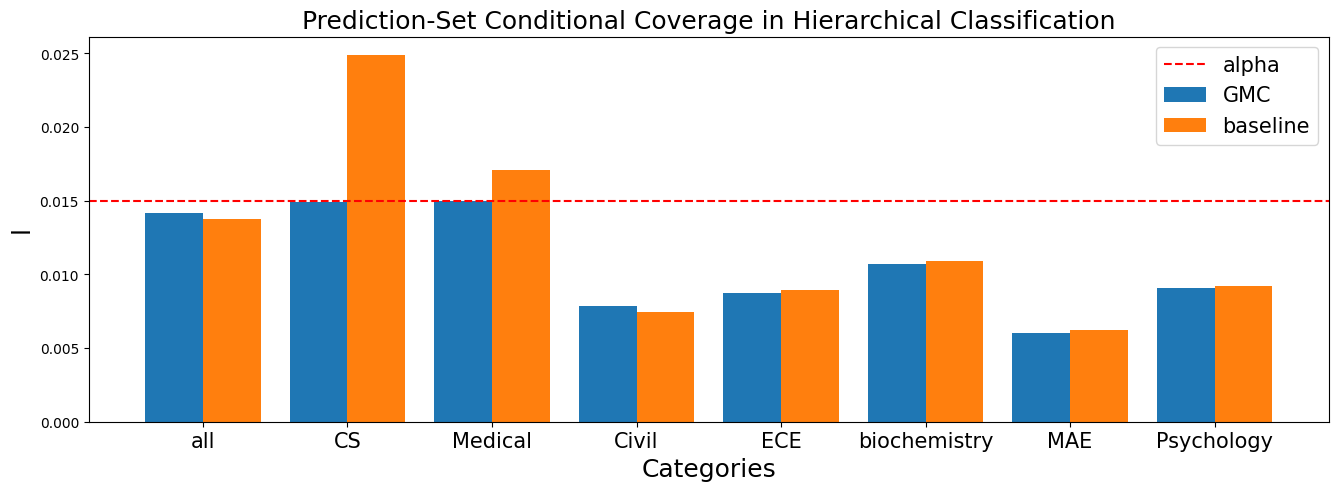

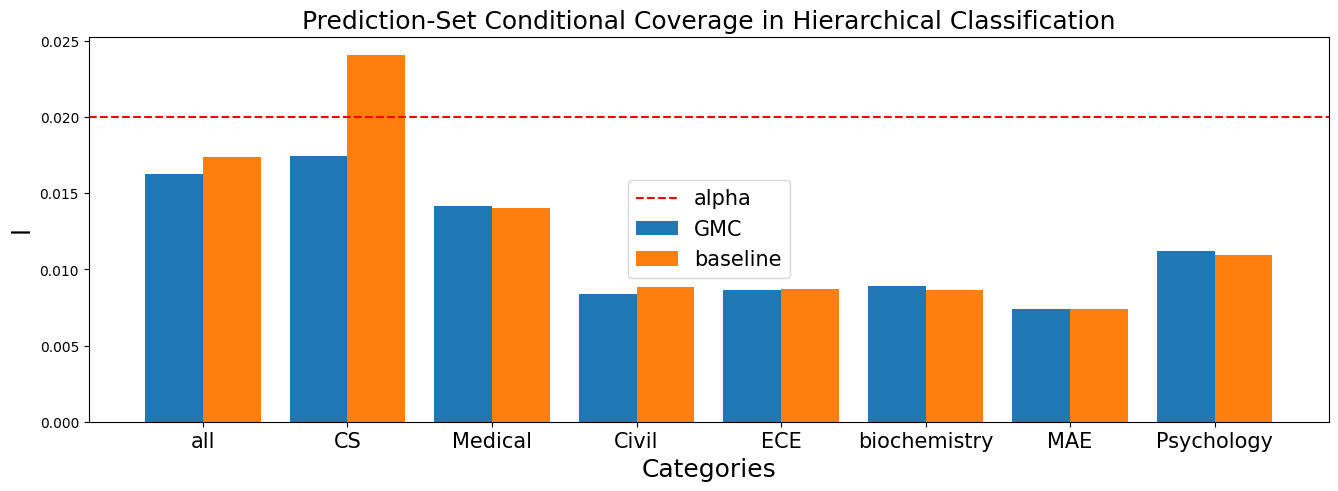

In [12]:
selected_G = G[:8]
def eval(G, s, fx, x, y, h):
    S = []
    n = x.shape[0]
    for g in G:
        output = (x[:,3:]>fx[:,None].repeat(3, axis=-1)).astype('int64')
        output[:,1:] -= output[:,:2]
        output = np.sum(output*x[:,:3], axis=-1)
        S.append(g(output)@s(fx,x,y,h)/n)
    return np.array(S)


category = ['all'] + list(label_dict.values())[:7]
# category = ['all', 'average size', 'bigger size', 'smaller size']
cal_result = eval(selected_G, s, fx, ancestor_cal, y_cal, h_cal)
cal_result_b = eval(selected_G, s, fx_b, ancestor_cal, y_cal, h_cal)
test_result = eval(selected_G, s, fx_test, ancestor_test, y_test, h_test)
test_result_b = eval(selected_G, s, fx_test_b, ancestor_test, y_test, h_test)

plot_result(category, np.abs(cal_result), np.abs(cal_result_b), 'Categories', 'l', 'Prediction-Set Conditional Coverage in Hierarchical Classification',alpha*3/4)
plot_result(category, np.abs(test_result), np.abs(test_result_b), 'Categories', 'l', 'Prediction-Set Conditional Coverage in Hierarchical Classification',alpha)